<div style="text-align: center; font-weight: bold; font-size: 300%">Projet INF473V</div>                                                        <br /> 
<div style="text-align: center; font-weight: bold; font-size: 180%">Processing - ResNet-50 - 4 classes </div>                                                        <br />
<div style="text-align: center; font-size: 150%">École Polytechnique, juin 2020</div><br />
<div style="text-align: center; font-size: 120%">Youssef Allouah et Paul Calot</div>**

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision
import matplotlib.pyplot as plt # to show img
from tqdm.notebook import tqdm
import torch.nn as nn
from matplotlib.lines import Line2D

In [2]:
root_dir = ''
trset = torch.load(root_dir + "datasets_6")
tsset = torch.load(root_dir + "testing_dataset_60")

In [3]:
class tweakedDataset(Dataset):
    
    def __init__(self, dts, cuda=True):
        self.dts = dts
        self.df = pd.DataFrame(np.zeros(dts.__len__()))
        self.cuda=cuda
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        images, labels = self.dts.__getitem__(idx)
        if self.cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        else:
            images = images.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)            
        return images, labels

training_set = tweakedDataset(trset)#, cuda=False)
testing_set = tweakedDataset(tsset)#, cuda=False)

In [4]:
# print proportion
def show_proportion(training_set, testing_set):
    train_size = len(training_set)
    test_size = len(testing_set)
    per_train = [0,0,0,0]
    per_test = [0,0,0,0]
    for k in range(train_size):
      per_train[int(training_set[k][1].item())]+=1

    for k in range(test_size):
      per_test[int(testing_set[k][1].item())]+=1

    for k in range(4):
      per_train[k] = round(per_train[k]/train_size,4)
      per_test[k] = round(per_test[k]/test_size,4)

    df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_train})
    ax1 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
    ax1.set_title('Training set repartition')
    fig1 = ax1.get_figure()
    for p in ax1.patches:
        ax1.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height() * 1.005))

    df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_test})
    ax2 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
    ax2.set_title('Testing set repartition')
    fig2 = ax2.get_figure()

    for p in ax2.patches:
        ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.006))

    fig1.savefig('train_repartition.png', dpi=400)
    fig2.savefig('test_repartition.png', dpi=400)

    print(f'Size of training set: {train_size} \nSize of testing set: {test_size}')

show_proportion(training_set, testing_set)

In [5]:
class EarlyStopping:
# The following code was inspired from this open-source project: https://colab.research.google.com/github/sanchit2843/MLBasics/blob/master/IntelClassificationKaggle/Pytorch%20transfer%20learning%20tutorial%20%5B93%25acc%5D.ipynb
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'resnet50checkpoint.pt')
        self.val_loss_min = val_loss

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          _, predicted = torch.max(outputs.data, 1)
#           target = torch.argmax(labels, dim=1)
#           loss+= criterion(outputs, target).item()
          loss+= criterion(outputs, labels).item()
          total += labels.size(0)
#           correct += (predicted == target).sum().item()
          correct += (predicted == labels).sum().item()
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  return (100.0 * correct / total, float(loss)/total)
  # return 100.0 * correct / total

# The following functions for gradient flow plotting were inspired from the following open-source project: https://github.com/alwynmathew/gradflow-check
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])    

def plot_grad_flow2(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
def smartrain(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 1,
          cuda=True,
          patience=None):
  loss_train = []
  acc_train = []
  loss_test = []
  acc_test = []
  total = 0
  if(patience!=None):
      earlystop = EarlyStopping(patience = patience,verbose = True)
  for epoch in range(n_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
#           target = torch.argmax(labels, dim=1)
          loss = criterion(outputs, labels)
#           loss = criterion(outputs, target)
          loss.backward()
        
          plot_grad_flow2(net.named_parameters())
        
          optimizer.step()
          total += labels.size(0)
          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss

          _, predicted = torch.max(outputs.data, 1)
#           target = torch.argmax(labels, dim=1)
#           correct = (predicted == target).sum().item()/labels.size(0)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.33*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            # break
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          loss_test.append(cur_loss)
          acc_test.append(cur_acc)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
          earlystop(cur_loss,net)
        
          # training set
          cur_acc, cur_loss = accuracy(net, train_loader, cuda=cuda)
          acc_train.append(cur_acc)
          loss_train.append(cur_loss)

      if(earlystop.early_stop):
          print("Early stopping")
          net.load_state_dict(torch.load('./resnet50checkpoint.pt'))
          break
      
  print('Finished Training')
  return loss_train, acc_train, loss_test, acc_test


In [6]:
#statistical tools

# !pip install seaborn
import seaborn as sn
import pandas as pd
def confusion_matrix(model, dataloader, size = 4, name = "Test", cuda = True): # here there are four classe
      model.eval()
      mat = np.zeros((size,size))
      total = 0
      corr = 0
      qty = [0,0,0,0]
      for images, labels in dataloader:
        if cuda:
          images = images.type(torch.cuda.FloatTensor)
          labels = labels.type(torch.cuda.LongTensor)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
         # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
          if(labels[k].item() == predicted[k].item()):
            corr +=1
          mat[labels[k].item(),predicted[k].item()]+=1
          qty[labels[k].item()]+=1
      for k in range(size):
        mat[k] *= 1/qty[k]
       # mat[k][size] = qty[k]/total # to have the total of images that the given class represented in the testing dataset
      model.train()
      dataframe = pd.DataFrame(mat, index=['healthy', 'multiple', 'rust', 'scab'])

      ax = plt.axes()

      svm = sn.heatmap(dataframe, annot=True, ax= ax)
      ax.set_title('Accuracy ' + name + " : " + str(round(corr / total,3)))
      figure = svm.get_figure()    
      figure.savefig('conf_mat' + name +'.png', dpi=400)

def plot(loss_train, acc_train, loss_test, acc_test):
    fig, axes = plt.subplots(nrows=1, ncols=2)#, figsize=(5, 3))
    axes[0].plot(range(1,1+len(loss_train)),loss_train, label='Train', color='b')
    axes[0].plot(range(1,1+len(loss_test)),loss_test, label= 'Test', color='r')
    axes[0].set_title('Train and test loss')

    axes[1].plot(range(1,1+len(acc_train)),acc_train, label= 'Train', color='b')
    axes[1].plot(range(1,1+len(acc_test)),acc_test, label= 'Test', color='r')
    axes[1].set_title('Train and test accuracy')
    
    fig.savefig('resnet50_modelperformance.png', dpi=400)

In [7]:
# !pip install torchsummary
from torchsummary import summary
model=torchvision.models.resnet50(pretrained=True)
# summary(model.cuda(),(3,224,224))

In [7]:
model=torchvision.models.resnet50(pretrained=True)


def frzlays(model=model, choice = 'last'):
    m = 0
    n = 0
    for child in model.fc.children():
        for param in child.parameters():
            m+=1
    for child in model.children():
        for param in child.parameters():
            n+=1
    l = n-m
    print(f'Total number of layers: n={n}\nNumber of layers in classifier: m={m}\nNumber of layers in backbone: l={l}')
    if choice == 'all':
        #freeze all net
        return n
    if choice == 'verylast':
        #unfreeze very last fc layer only
        return n-1
    if choice == 'last':
        #unfreeze last fc layer only
        return n-2
    if choice == 'classifier':
        #unfreeze classifier
        return n-m
    if choice == '2/3':
        #freeze only 2/3 of backbone
        return 2*l//3
    if choice == '1/5':
        #freeze only 1/5 of backbone
        return l//5
    if choice == 'none':
        #freeze none
        return 0  

In [8]:
def init_and_freeze(choice):
    model=torchvision.models.resnet50(pretrained=True)
    lin = model.fc
    new_lin = nn.Sequential(lin,nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(1000,4, bias = True))

    model.fc = new_lin

    freeze_layers = frzlays(model=model, choice=choice)
    k=0 
    for child in model.children():
        for param in child.parameters():
          k += 1
          if(k < freeze_layers ):
              param.requires_grad = False
          else:
              param.requires_grad = True
    return model

model = init_and_freeze('all')

Total number of layers: n=163
Number of layers in classifier: m=4
Number of layers in backbone: l=159


In [10]:
# !pip install pytorch-lr-finder
from pytorch_lr_finder import LearningRateFinder
def find_lr(model, criterion, optimizer):
    lrf = LearningRateFinder(model.cuda(), criterion, optimizer)
    lrf.fit(train_loader)
    lrf.plot()
    lrf.reset()

# First choice of freezing

In [27]:
model = init_and_freeze('verylast')
print(summary(model.cuda(), (3, 224, 224)))

Total number of layers: n=163
Number of layers in classifier: m=4
Number of layers in backbone: l=159
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
 

In [28]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

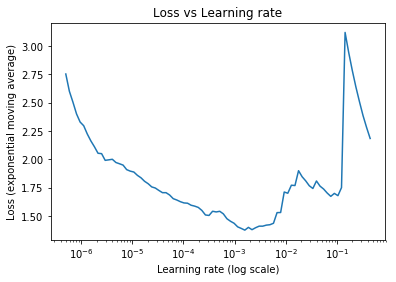

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
find_lr(model, criterion, optimizer)

[1,    10] loss: 0.019
[1,    10] acc: 0.439
[1,    20] loss: 0.017
[1,    20] acc: 0.470
[1,    30] loss: 0.015
[1,    30] acc: 0.559
[1,    40] loss: 0.015
[1,    40] acc: 0.565
[1,    50] loss: 0.014
[1,    50] acc: 0.599
Accuracy of the network on the test images: 72 %
[1] loss: 0.733
[1] acc: 72.977
Validation loss decreased (inf --> 0.733205).  Saving model ...
Accuracy of the network on the test images: 70 %
[2,    10] loss: 0.013
[2,    10] acc: 0.604
[2,    20] loss: 0.012
[2,    20] acc: 0.655
[2,    30] loss: 0.011
[2,    30] acc: 0.661
[2,    40] loss: 0.012
[2,    40] acc: 0.652
[2,    50] loss: 0.012
[2,    50] acc: 0.652
Accuracy of the network on the test images: 78 %
[2] loss: 0.611
[2] acc: 78.464
Validation loss decreased (0.733205 --> 0.610991).  Saving model ...
Accuracy of the network on the test images: 76 %
[3,    10] loss: 0.010
[3,    10] acc: 0.705
[3,    20] loss: 0.012
[3,    20] acc: 0.661
[3,    30] loss: 0.011
[3,    30] acc: 0.683
[3,    40] loss: 0.012

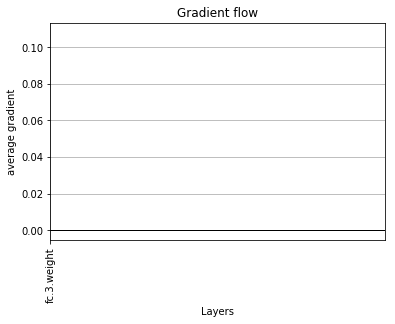

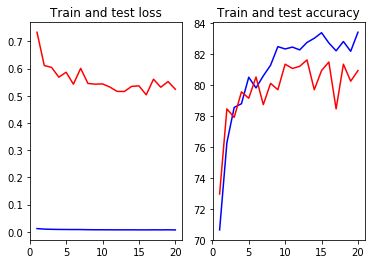

In [29]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 5,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

# Second choice of freezing

In [19]:
model = init_and_freeze('last')
print(summary(model.cuda(), (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

NameError: name 'training_set' is not defined

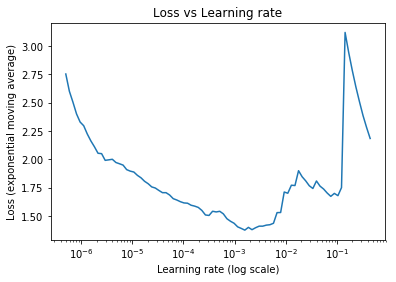

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
find_lr(model, criterion, optimizer)

[1,    10] loss: 0.020
[1,    10] acc: 0.324
[1,    20] loss: 0.021
[1,    20] acc: 0.355
[1,    30] loss: 0.020
[1,    30] acc: 0.357
Accuracy of the network on the test images: 54 %
[1] loss: 1.206
[1] acc: 54.321
Validation loss decreased (inf --> 1.205508).  Saving model ...
Accuracy of the network on the test images: 44 %
[2,    10] loss: 0.021
[2,    10] acc: 0.375
[2,    20] loss: 0.020
[2,    20] acc: 0.417
[2,    30] loss: 0.019
[2,    30] acc: 0.422
Accuracy of the network on the test images: 54 %
[2] loss: 1.178
[2] acc: 54.458
Validation loss decreased (1.205508 --> 1.178487).  Saving model ...
Accuracy of the network on the test images: 45 %
[3,    10] loss: 0.020
[3,    10] acc: 0.412
[3,    20] loss: 0.019
[3,    20] acc: 0.458
[3,    30] loss: 0.020
[3,    30] acc: 0.375
Accuracy of the network on the test images: 57 %
[3] loss: 1.138
[3] acc: 57.064
Validation loss decreased (1.178487 --> 1.137819).  Saving model ...
Accuracy of the network on the test images: 46 %
[4,

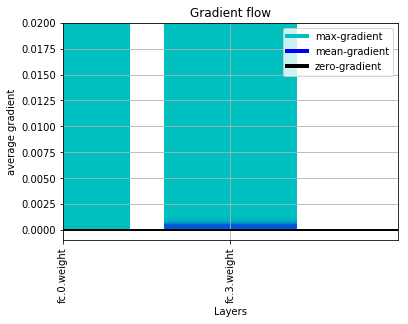

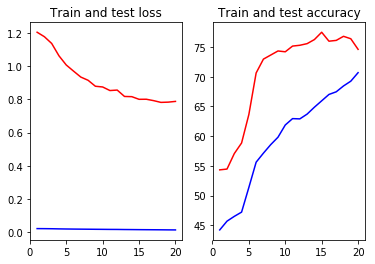

In [22]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 5,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

# Third choice of Freezing

In [22]:
model = init_and_freeze('2/3')
print(summary(model.cuda(), (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

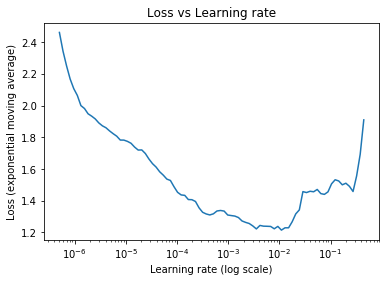

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
find_lr(model, criterion, optimizer)

In [37]:
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


[1,    10] loss: 0.037
[1,    10] acc: 0.210
[1,    20] loss: 0.022
[1,    20] acc: 0.291
[1,    30] loss: 0.019
[1,    30] acc: 0.297
Accuracy of the network on the test images: 33 %
[1] loss: 1.365
[1] acc: 33.745
Validation loss decreased (inf --> 1.364823).  Saving model ...
Accuracy of the network on the test images: 32 %
[2,    10] loss: 0.019
[2,    10] acc: 0.298
[2,    20] loss: 0.020
[2,    20] acc: 0.354
[2,    30] loss: 0.019
[2,    30] acc: 0.360
Accuracy of the network on the test images: 34 %
[2] loss: 1.245
[2] acc: 34.705
Validation loss decreased (1.364823 --> 1.245132).  Saving model ...
Accuracy of the network on the test images: 33 %
[3,    10] loss: 0.019
[3,    10] acc: 0.312
[3,    20] loss: 0.019
[3,    20] acc: 0.317
[3,    30] loss: 0.019
[3,    30] acc: 0.351
Accuracy of the network on the test images: 36 %
[3] loss: 1.222
[3] acc: 36.077
Validation loss decreased (1.245132 --> 1.222048).  Saving model ...
Accuracy of the network on the test images: 33 %
[4,

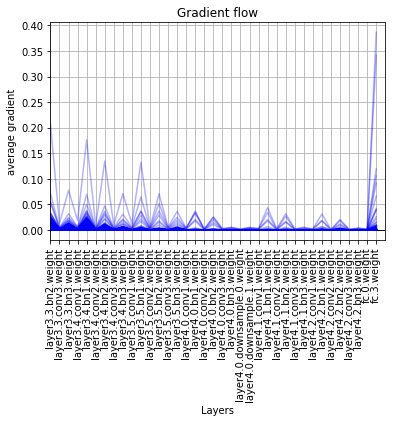

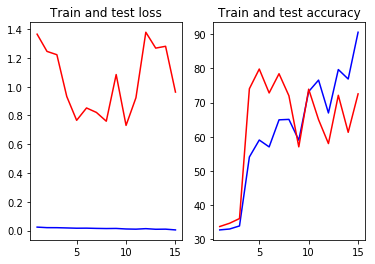

In [38]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 5,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

# Fourth choice of Freezing

Without weight coefficienting, results were poor, so I directly showed results only with weight coefficienting

In [23]:
model = init_and_freeze('1/5')
print(summary(model.cuda(), (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
class_weights = torch.FloatTensor([1/0.2767, 1/0.0805, 1/0.3263, 1/0.3165]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=False)

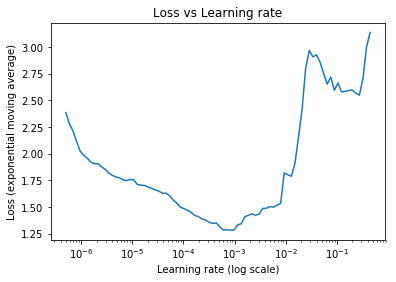

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
find_lr(model, criterion, optimizer)

In [30]:
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[1,    10] loss: 0.897
[1,    10] acc: 0.301
[1,    20] loss: 1.032
[1,    20] acc: 0.332
[1,    30] loss: 1.017
[1,    30] acc: 0.295
Accuracy of the network on the test images: 32 %
[1] loss: 45.153
[1] acc: 32.099
Validation loss decreased (inf --> 45.153033).  Saving model ...
Accuracy of the network on the test images: 31 %
[2,    10] loss: 1.077
[2,    10] acc: 0.297
[2,    20] loss: 0.887
[2,    20] acc: 0.305
[2,    30] loss: 1.734
[2,    30] acc: 0.318
Accuracy of the network on the test images: 32 %
[2] loss: 26.372
[2] acc: 32.099
Validation loss decreased (45.153033 --> 26.371782).  Saving model ...
Accuracy of the network on the test images: 31 %
[3,    10] loss: 0.805
[3,    10] acc: 0.321
[3,    20] loss: 1.056
[3,    20] acc: 0.286
[3,    30] loss: 0.667
[3,    30] acc: 0.292
Accuracy of the network on the test images: 32 %
[3] loss: 25.893
[3] acc: 32.099
Validation loss decreased (26.371782 --> 25.892885).  Saving model ...
Accuracy of the network on the test images: 

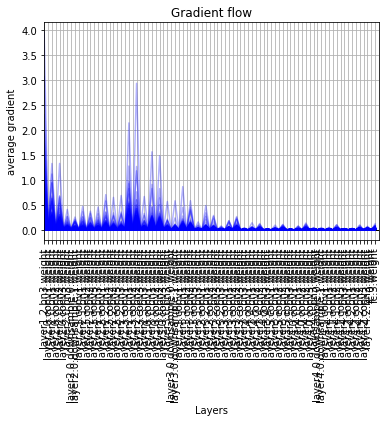

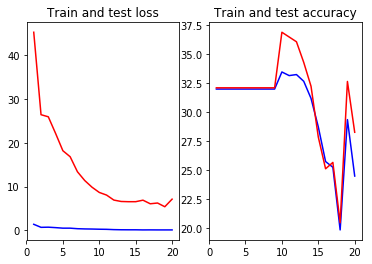

In [31]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 5,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

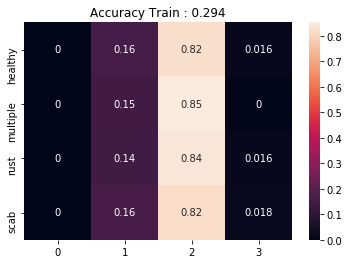

In [32]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

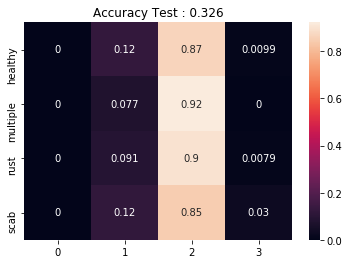

In [33]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)

# Fifth choice of Freezing

In [11]:
model = init_and_freeze('none')

In [12]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

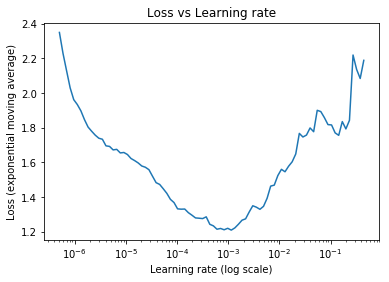

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
find_lr(model, criterion, optimizer)

In [13]:
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


[1,    10] loss: 0.020
[1,    10] acc: 0.368
[1,    20] loss: 0.020
[1,    20] acc: 0.419
[1,    30] loss: 0.019
[1,    30] acc: 0.491
Accuracy of the network on the test images: 78 %
[1] loss: 0.746
[1] acc: 78.052
Validation loss decreased (inf --> 0.746265).  Saving model ...
Accuracy of the network on the test images: 67 %
[2,    10] loss: 0.012
[2,    10] acc: 0.679
[2,    20] loss: 0.011
[2,    20] acc: 0.687
[2,    30] loss: 0.012
[2,    30] acc: 0.631
Accuracy of the network on the test images: 82 %
[2] loss: 0.606
[2] acc: 82.305
Validation loss decreased (0.746265 --> 0.606204).  Saving model ...
Accuracy of the network on the test images: 86 %
[3,    10] loss: 0.007
[3,    10] acc: 0.788
[3,    20] loss: 0.007
[3,    20] acc: 0.819
[3,    30] loss: 0.007
[3,    30] acc: 0.818
Accuracy of the network on the test images: 79 %
[3] loss: 0.609
[3] acc: 79.150
EarlyStopping counter: 1 out of 7
Accuracy of the network on the test images: 98 %
[4,    10] loss: 0.003
[4,    10] acc:

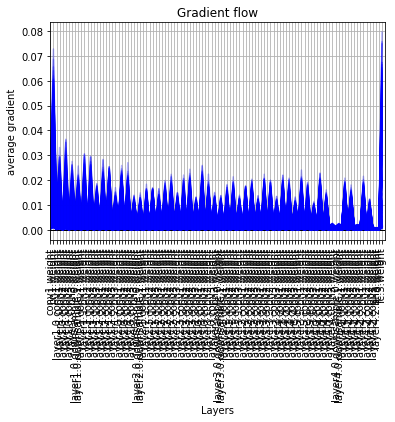

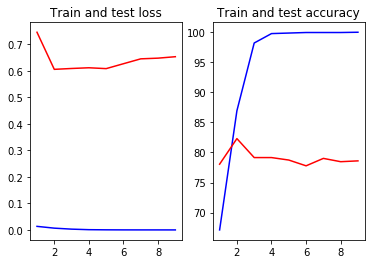

In [14]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 30,
      patience = 7,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

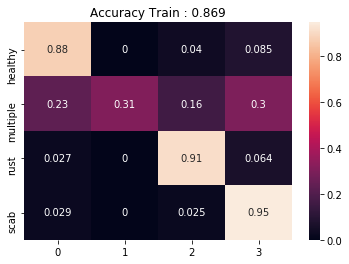

In [13]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

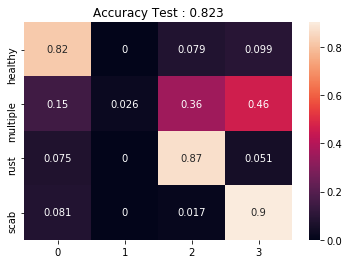

In [14]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)

# Performance on augmented training dataset

Total number of layers: n=163
Number of layers in classifier: m=4
Number of layers in backbone: l=159
Size of training set: 4524 
Size of testing set: 729


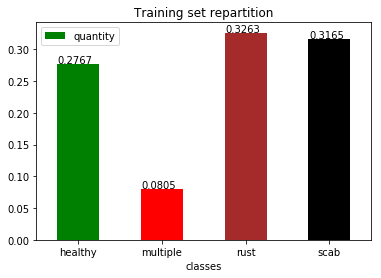

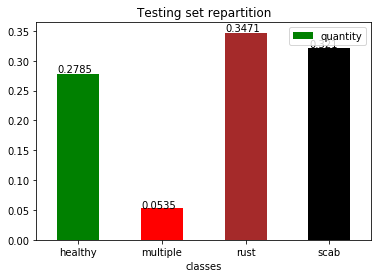

In [9]:
model = init_and_freeze('none')
batch_size = 64
learning_rate = 0.001
# class_weights = torch.FloatTensor([1/0.2767, 1/0.0805, 1/0.3263, 1/0.3165]).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

trset = torch.load(root_dir + "datasets_8")
training_set = tweakedDataset(trset)#, cuda=False)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
show_proportion(training_set, testing_set)

/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


[1,    10] loss: 0.018
[1,    10] acc: 0.597
[1,    20] loss: 0.010
[1,    20] acc: 0.766
[1,    30] loss: 0.009
[1,    30] acc: 0.784
[1,    40] loss: 0.007
[1,    40] acc: 0.831
[1,    50] loss: 0.007
[1,    50] acc: 0.819
[1,    60] loss: 0.006
[1,    60] acc: 0.841
[1,    70] loss: 0.008
[1,    70] acc: 0.797
Accuracy of the network on the test images: 79 %
[1] loss: 0.728
[1] acc: 79.424
Validation loss decreased (inf --> 0.727925).  Saving model ...
Accuracy of the network on the test images: 77 %
[2,    10] loss: 0.006
[2,    10] acc: 0.828
[2,    20] loss: 0.006
[2,    20] acc: 0.833
[2,    30] loss: 0.005
[2,    30] acc: 0.866
[2,    40] loss: 0.004
[2,    40] acc: 0.885
[2,    50] loss: 0.006
[2,    50] acc: 0.857
[2,    60] loss: 0.006
[2,    60] acc: 0.831
[2,    70] loss: 0.005
[2,    70] acc: 0.884
Accuracy of the network on the test images: 87 %
[2] loss: 0.377
[2] acc: 87.791
Validation loss decreased (0.727925 --> 0.376976).  Saving model ...
Accuracy of the network on

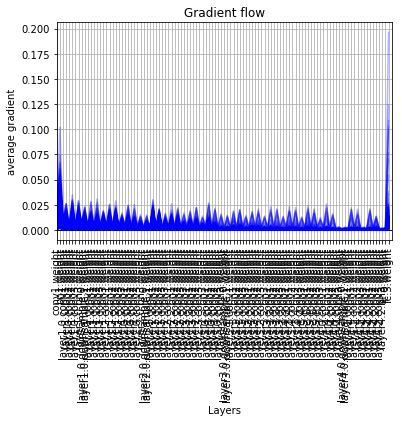

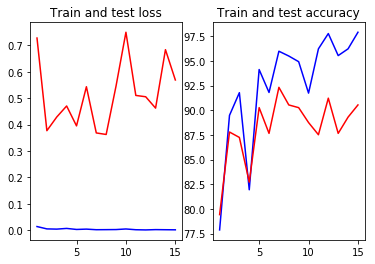

In [10]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 7,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

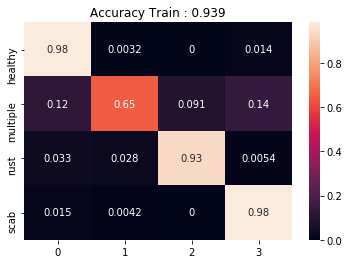

In [12]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

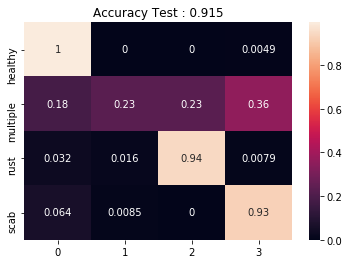

In [13]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)

In [11]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
torch.save(model, 'unweightedresnet50')

# Weight adaptation

Size of training set: 4524 
Size of testing set: 729


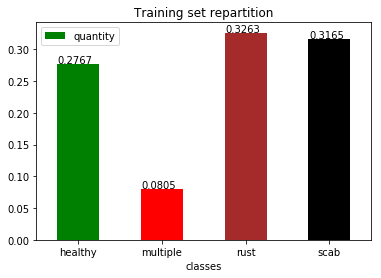

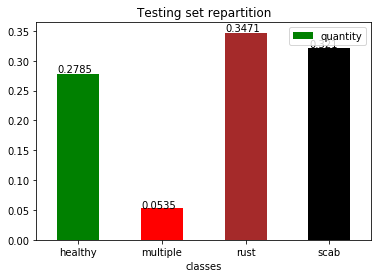

In [11]:
model = init_and_freeze('none')
batch_size = 8
learning_rate = 0.001
class_weights = torch.FloatTensor([1/0.2767, 1/0.0805, 1/0.3263, 1/0.3165]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

trset = torch.load(root_dir + "datasets_8")
training_set = tweakedDataset(trset)#, cuda=False)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
show_proportion(training_set, testing_set)

/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


[1,    10] loss: 0.017
[1,    10] acc: 0.525
[1,    20] loss: 0.015
[1,    20] acc: 0.653
[1,    30] loss: 0.015
[1,    30] acc: 0.610
[1,    40] loss: 0.015
[1,    40] acc: 0.679
[1,    50] loss: 0.013
[1,    50] acc: 0.764
[1,    60] loss: 0.012
[1,    60] acc: 0.683
[1,    70] loss: 0.012
[1,    70] acc: 0.715
Accuracy of the network on the test images: 80 %
[1] loss: 0.682
[1] acc: 80.796
Validation loss decreased (inf --> 0.682336).  Saving model ...
Accuracy of the network on the test images: 80 %
[2,    10] loss: 0.007
[2,    10] acc: 0.799
[2,    20] loss: 0.011
[2,    20] acc: 0.753
[2,    30] loss: 0.009
[2,    30] acc: 0.792
[2,    40] loss: 0.008
[2,    40] acc: 0.807
[2,    50] loss: 0.008
[2,    50] acc: 0.834
[2,    60] loss: 0.009
[2,    60] acc: 0.760
[2,    70] loss: 0.007
[2,    70] acc: 0.840
Accuracy of the network on the test images: 79 %
[2] loss: 0.612
[2] acc: 79.698
Validation loss decreased (0.682336 --> 0.612425).  Saving model ...
Accuracy of the network on

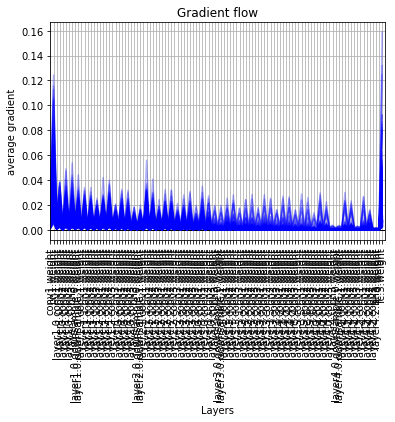

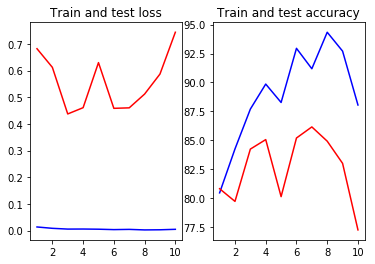

In [15]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 7,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

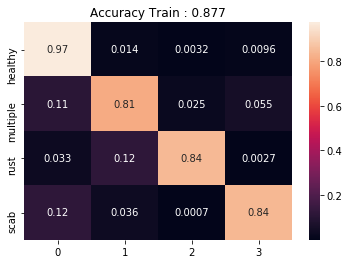

In [12]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

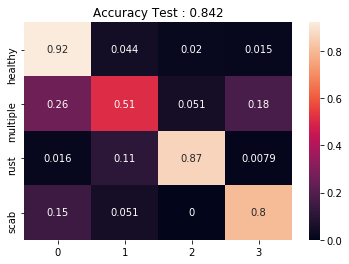

In [13]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)

In [4]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))

<All keys matched successfully>

In [5]:
torch.save(model, 'weightedresnet50')

# Performance on augmented training dataset 2

We tested on a different dataset: dataset 4. It is smaller than the previous, but more balanced.

Size of training set: 3344 
Size of testing set: 729


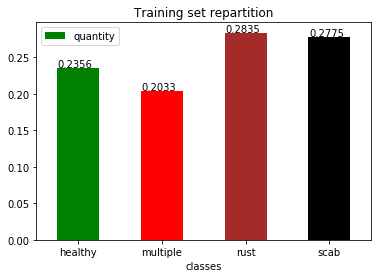

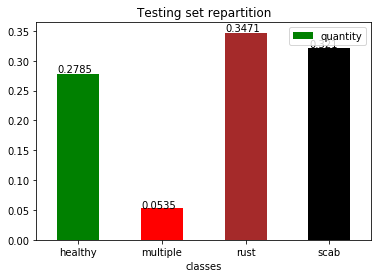

In [19]:
model = init_and_freeze('none')
batch_size = 64
learning_rate = 0.001
# class_weights = torch.FloatTensor([1/0.2356, 1/0.2033, 1/0.2835, 1/0.2775]).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

trset = torch.load(root_dir + "dataset_4")
training_set = tweakedDataset(trset)#, cuda=False)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
show_proportion(training_set, testing_set)

In [20]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 7,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

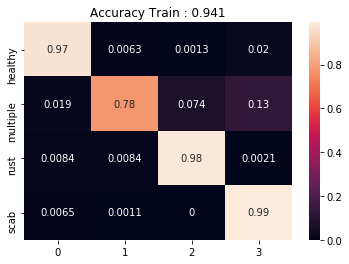

In [14]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

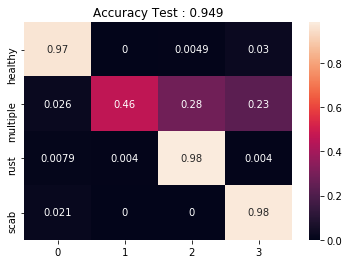

In [15]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)

# Weight adaptation

Size of training set: 3344 
Size of testing set: 729


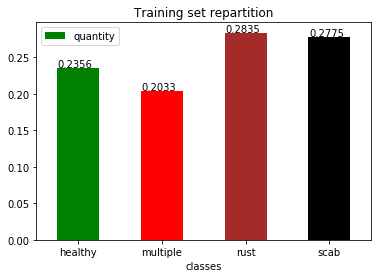

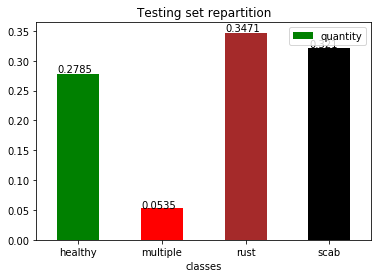

In [11]:
model = init_and_freeze('none')
batch_size = 16
learning_rate = 0.001
class_weights = torch.FloatTensor([1/0.2356, 1/0.2033, 1/0.2835, 1/0.2775]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loader = torch.utils.data.DataLoader(testing_set,batch_size=1, shuffle=True)

trset = torch.load(root_dir + "dataset_4")
training_set = tweakedDataset(trset)#, cuda=False)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size, shuffle=True)
show_proportion(training_set, testing_set)

[1,    10] loss: 0.023
[1,    10] acc: 0.404
[1,    20] loss: 0.015
[1,    20] acc: 0.607
[1,    30] loss: 0.013
[1,    30] acc: 0.616
[1,    40] loss: 0.011
[1,    40] acc: 0.681
[1,    50] loss: 0.011
[1,    50] acc: 0.692
Accuracy of the network on the test images: 75 %
[1] loss: 0.815
[1] acc: 75.034
Validation loss decreased (inf --> 0.814976).  Saving model ...
Accuracy of the network on the test images: 63 %
[2,    10] loss: 0.012
[2,    10] acc: 0.682
[2,    20] loss: 0.013
[2,    20] acc: 0.729
[2,    30] loss: 0.010
[2,    30] acc: 0.712
[2,    40] loss: 0.011
[2,    40] acc: 0.704
[2,    50] loss: 0.008
[2,    50] acc: 0.806
Accuracy of the network on the test images: 63 %
[2] loss: 1.031
[2] acc: 63.786
EarlyStopping counter: 1 out of 7
Accuracy of the network on the test images: 62 %
[3,    10] loss: 0.009
[3,    10] acc: 0.784
[3,    20] loss: 0.008
[3,    20] acc: 0.782
[3,    30] loss: 0.008
[3,    30] acc: 0.787
[3,    40] loss: 0.007
[3,    40] acc: 0.797
[3,    50] l

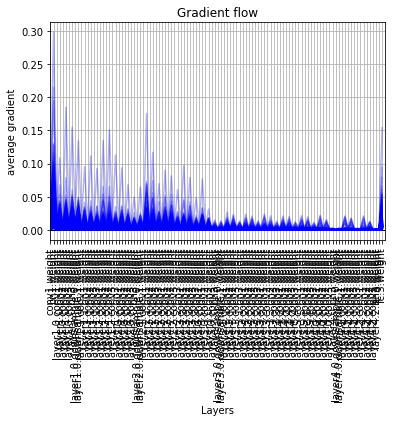

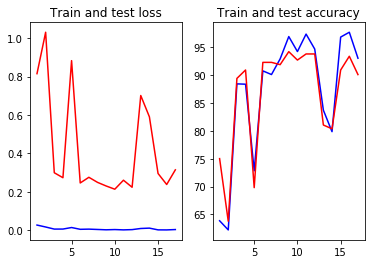

In [17]:
model.cuda()
loss_train, acc_train, loss_test, acc_test = smartrain(model, optimizer, train_loader, test_loader, criterion,  n_epoch = 20,
      patience = 7,
      train_acc_period = 10,
      test_acc_period = 1)
accuracy(model, test_loader, cuda=True)
plot(loss_train, acc_train, loss_test, acc_test)

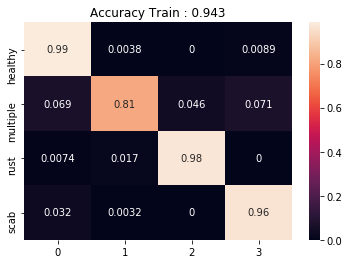

In [12]:
model.load_state_dict(torch.load('resnet50checkpoint.pt'))
confusion_matrix(model.cuda(), train_loader, size = 4, name = "Train", cuda = True)

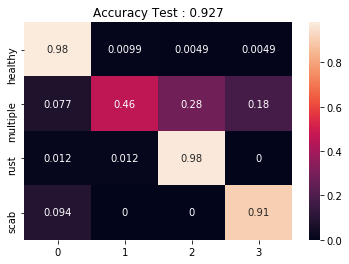

In [13]:
confusion_matrix(model, test_loader, size = 4, name = "Test", cuda = True)